# Conservation Analysis and Epitope Prediction


#### Author: C. Mazzaferro, K. Fisch
#### Email: cmazzafe@ucsd.edu
#### Date: August 2016
 
## Outline of Notebook
<a id = "toc"></a>
1. <a href = "#background">Background</a>
2. <a href = "#Real">Realignment</a>
3. <a href = "#Cons">Conservation Analysis</a>
4. <a href = "#affin">Affinty Binding Scoring</a>
5. <a href = "#summ">Summarizing Data</a>

<a id = "background"></a>
# Background

CRISPR (clustered regularly interspaced short palindromic repeat) is an adaptive immune system that provides protection against mobile genetic elements (viruses, transposable elements and conjugative plasmids).
CRISPR clusters contain spacers, sequences complementary to antecedent mobile elements, and target invading nucleic acids. CRISPR clusters are transcribed and processed into CRISPR RNA (crRNA). In type II CRISPR systems correct processing of pre-crRNA requires a trans-encoded small RNA (tracrRNA), endogenous ribonuclease 3 (rnc) and this protein. The tracrRNA serves as a guide for ribonuclease 3-aided processing of pre-crRNA; Cas9 only stabilizes the pre-crRNA:tracrRNA interaction and has no catalytic function in RNA processing. Subsequently Cas9/crRNA/tracrRNA endonucleolytically cleaves linear or circular dsDNA target complementary to the spacer; Cas9 is inactive in the absence of the 2 guide RNAs (gRNA). The target strand not complementary to crRNA is first cut endonucleolytically, then trimmed 3'-5' exonucleolytically. DNA-binding requires protein and both gRNAs, as does nuclease activity. Cas9 recognizes the protospacer adjacent motif (PAM) in the CRISPR repeat sequences to help distinguish self versus nonself, as targets within the bacterial CRISPR locus do not have PAMs. DNA strand separation and heteroduplex formation starts at PAM sites; PAM recognition is required for catalytic activity (PubMed:24476820). Confers immunity against a plasmid with homology to the appropriate CRISPR spacer sequences (CRISPR interference) (PubMed:21455174)

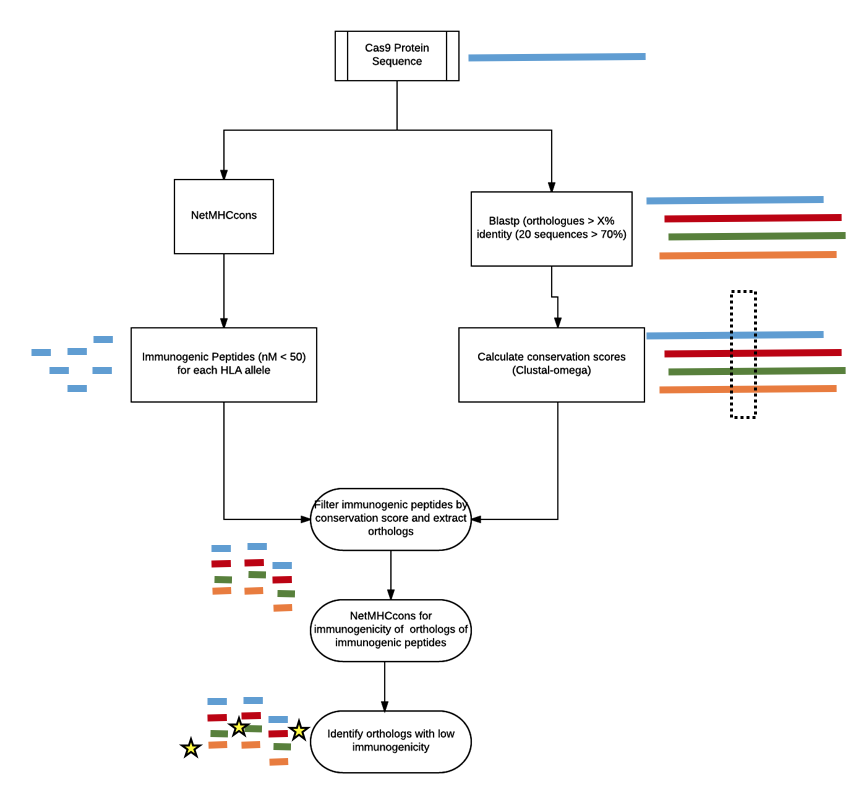

In [96]:
from IPython.display import Image
Image("/Users/carlomazzaferro/Desktop/BINF Int Rand Pics/workflow_epitope.png")

The pipeline presented here is aimed at identify the most immunogenic peptides in Cas9. By looking at multiple sequence alignment scores for the possible peptides and their associated predicted MHC affinity, we can determine which peptides within a Cas9 orthologue can be swapped in order to reduce overall immunogenecity.

This 'Base Worflow' implements the following steps: 

1. Select proteins [from reference papaer](http://nar.oxfordjournals.org/content/suppl/2013/10/29/gkt1074.DC1/nar-02672-z-2013-File008.pdf)
2. Peform Multiple Sequence Alignement (MSA) using locally installed [Clustal Omega](http://www.clustal.org/omega/) in order to determine conservation scores
3. Calculate conservation scores for each n-mer (sizes 9, 10, 11) of the MSA
4. Predict the MHC affinity of each peptide using [CBS's prediction services](http://www.cbs.dtu.dk/services/), in particular [netMHCcons Server](http://www.cbs.dtu.dk/services/NetMHCcons/)
5. Output list of highly low-conservation, high affinity peptides for in-vitro research


From these results, three different workflowsm for peptide identification were constructed.

<a id = "Real"></a>
# Realigning Sequence

msa_utils.Alignment will automatically create a MSA fasta file and an html MSA file for easy viewing. 

In [6]:
import importlib

from nepitope import msa_utils

ref_prot_id = 'S__pyogenes_Cas9'

PROJECT_LOC = '/Users/carlomazzaferro/Desktop/New_General/'

msa_file = '/Users/carlomazzaferro/Desktop/New_General/msa_stuff/msa_new_prots.fasta'
MSA_STUFF = msa_utils.Alignment(fasta_file, ref_prot_id)

MSA in fasta created to /Users/carlomazzaferro/Desktop/New_General/alignment/MSA.fasta
MSA in html created to /Users/carlomazzaferro/Desktop/New_General/alignment/MSA_easy_viewing.html


In [7]:
MSA_STUFF.visualize_alignemnt()

In [8]:
MSA_STUFF.reference_protein_id, MSA_STUFF.reference_protein_string

('S__pyogenes_Cas9',
 '------MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGET----------AEATRLKRTARRRYTRRKNRICYLQEIFSNEMAKVDD-----------S-FFHRLEESFLVEEDKKHERH-PIFG-NIVDEVAYHEKYPT--IYHLRKKLVD------STDKA------------DLRLIYLALA-HMIKFRGHFLIEGDLNPDNSDVD------KLFIQLVQTYNQLFEENPIN------ASGVDAK-AILS-ARLSKSRRLE---NLIAQLPG---EK-----KNGLFGNLIALSLGLTPNFKSNFDLA-----EDAKLQLSKDTYDDDLDNLLAQIGDQYADLFLAAKNLSDA-ILLSDILRVNTEITKAPLSASMIKRYDEHHQDLTLLKALVRQQLPEKYKEIFFD--------------QSKNGYA------------------GY------------IDGGASQEEF--YKFIKPILEK---MDGTEELLVKLNREDLLRKQR------------------TFDNGSIPHQIHLGELHAILRRQEDFYPFLKDN----------REKIEKILTFRIPYYVGPLARG-------NSRFAWMTRKS-E--ETITPWNFEEVVDKGASAQSFIERMTNFDKNLPNEKVLPKHSLLYEYFTVYNELTKVKYVTEGMRKPAFLSGEQKKAIVDLL--------FKTNRKVTVKQLKEDYFKKIECF-DSVEISGV---E----------------------DRFN-----ASLGTYHDLLKIIKD-KDFLDNEE----NE----------------DILEDIVL-------TLTLFEDRE---MIEER-LKTYA--HLFDDKVMKQLKR---------------------RRYTGWGRLSRKLINGIR---DKQSGKTIL-DFLKSDGFANRNFMQLIHDDSLTFKEDIQK

Some attributes and methods:

In [9]:
MSA_STUFF.msa

TabularMSA[Protein]
-----------------------------------------------------------------------
Stats:
    sequence count: 17
    position count: 2017
-----------------------------------------------------------------------
------MDKKYSIGLDIGTNSVGWAVITDEYKV ... ---------------------------------
------MKRNYILGLDIGITSVGYGIIDYETR- ... PQIIKKG--------------------------
...
-----MKVNNYHIGLDIGTSSIGWVAIGKDGKP ... ---------------------------------
------MKKPYTIGLDIGTNSVGWAVLTDQYDL ... ---------------------------------

In [10]:
MSA_STUFF.positional_conservation

array([ 0.88102878,  0.88102878,  0.88102878, ...,  0.92651784,
        0.92651784,  0.92651784])

In [11]:
MSA_STUFF.reference_protein_string[0:80]

'------MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGET----------AEATRL'

In [12]:
nmers = [8,9,10,11]
scores_df = MSA_STUFF.create_score_df_from_scikit_bio(nmers)

In [13]:
scores_df.head()

,Score,Peptide,n-mer
0,0.701291,------MD,8
1,0.642542,-----MDK,8
2,0.569138,----MDKK,8
3,0.542697,---MDKKY,8
4,0.506955,--MDKKYS,8


<a id = "affin"></a>
# MHC Binding Affinity Prediction 
### Ran on netMHCcons for n-mers of 8, 9, 10, 11 amino acids and for the 12 allele supertype families

Run for a specific protein sequence - in reality this step will be performed for as many proteins as possible. In this case, S._Pyoegenes was used

#### NetMHC installation: download and install from instructions located [here]( http://www.cbs.dtu.dk/cgi-bin/nph-sw_request?netMHC)
Note: works on Darwin or Linux based OSs.

In [14]:
import importlib
from nepitope import net_MHC_interface

all_alleles = ['HLA-A0101','HLA-A0201','HLA-A0301','HLA-A2402','HLA-A2601',
               'HLA-B0702','HLA-B0801','HLA-B2705','HLA-B3901','HLA-B4001','HLA-B5801','HLA-B1501']
nmer_list = [8,9,10,11]


fasta_file = '/Users/carlomazzaferro/Desktop/New_General/alignment/MSA.fasta'
net_mhc_path = '/Users/carlomazzaferro/Desktop/BINF_Tools/netMHC-4.0/netMHC'

net_mhc = net_MHC_interface.netMHCComand(net_mhc_path, fasta_file, nmer_list, all_alleles)

In [15]:
net_mhc.create_text_command()

'netMHC commands written to run_netMHC.txt located at /Users/carlomazzaferro/Desktop/New_General/alignment/mhc_preds_MSA'

In [17]:
net_mhc.run_netMHC()

#### Create bash command to run netMHC
A text file named run_netMHC will be saved to your `out_dir`. To run it, `cd` into your `out_dir` from terminal and simply run:   `bash run_netMHC.txt`

#### Load file(s)

In [54]:
from nepitope import mhc_utils
from importlib import reload
reload(mhc_utils)

<module 'nepitope.mhc_utils' from '/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/mhc_utils.py'>

In [2]:
from nepitope import mhc_utils
import glob
import os
nmers = [8, 9,10,11]

#files saved from netMHCcons as split_*i*_prediction_*n*_mer for each split/nmer
fasta_file = '/Users/carlomazzaferro/Desktop/PROJECT_LOC_TEST/alignment/MSA.fasta'
filepath = '/Users/carlomazzaferro/Desktop/PROJECT_LOC_TEST/alignment/mhc_preds_MSA/'

aggregate_all = mhc_utils.FileConsolidation(filepath, fasta_file)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/carlomazzaferro/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


NameError: name 'fasta_file' is not defined

#### Return data in a list of dataframes, where each dataframe contains data about a protein
(May take some time)
In this case we only used one protein for the prediction, namely the CAS9 Streptococcus Pyogegenes.

In [135]:
df1 = aggregate_all.return_df_list()
lsss = aggregate_all.optimized_list_df_by_prot(df1)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### Viz data in first protein

In [136]:
lsss[0].sort_values(by='nM').head(10) #Some high affinity peps in protein BAV54116

,Pos,Peptide,nM,Rank,ID,Allele,Affinity Level,n-mer
1802,1802,EIIEQISEF,2.9,0.010,S__pyogenes_Cas9,HLA-A2601,High,9
876,876,KTYAXXHLF,4.1,0.015,S__pyogenes_Cas9,HLA-B5801,High,9
1521,1521,EVXXQTGGF,4.2,0.010,S__pyogenes_Cas9,HLA-A2601,High,9
680,680,SLLYEYFTV,5.1,0.030,S__pyogenes_Cas9,HLA-A0201,High,9
1465,1465,RPLXXXXXI,5.2,0.010,S__pyogenes_Cas9,HLA-B0702,High,9
1799,1799,YLDEIIEQI,5.5,0.040,S__pyogenes_Cas9,HLA-A0201,High,9
381,381,ILLSDILRV,5.6,0.040,S__pyogenes_Cas9,HLA-A0201,High,9
681,681,LLYEYFTVY,6.6,0.020,S__pyogenes_Cas9,HLA-B1501,High,9
1083,1083,KELGXSQIL,7.3,0.020,S__pyogenes_Cas9,HLA-B4001,High,9
1435,1435,KATAKYFXF,7.9,0.040,S__pyogenes_Cas9,HLA-B5801,High,9


#### Add conservation scores

In [138]:
from nepitope import scoring_utils

In [139]:
scores_and_affinity = scoring_utils.Score.add_conserv_score_to_df_list(lsss, scores_df)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1['Score'] = list_1


In [140]:
ss = scores_and_affinity[0][scores_and_affinity[0].Peptide.str.contains('--') == False].head()
# (Affinity Score U Cons Scorezx)

In [70]:
## Save as csv
csv_path = '/Users/carlomazzaferro/Desktop/CCBB_Results_Immune_Stealth_Analysis/protein_data_per_peptide.csv'
scores_and_affinity[0].to_csv(path_or_buf=csv_path, sep=',')

<a id = "summm"></a>
# Data Summary
The class SummaryData has two classmethods: summarize_all_data, and summarize_protein data. 
The first takes as input the entire list of dataframes retrived from the previous steps, while the second takes that alongside with the accession ID of a protein of choice. 

The main method implemented alogside with the first classmethod is return_dataframe. It will return a dataframe that summarizes key information for each protein. 

With summarize_protein_data, summary information regarding a specific protein is retrieved. Methods for plotting conservation scores against affinity levels are also present.

The object single protein can be interrogated in a variety of manners:
Attributes of single_prot:

- my_protein (protein name)
- title (alignment title)
- high_affinity_peps (number of high affinity peptides)
- med_affinity_peps (number of intermediate affinity peptides)
- low_affinity_peps (number of low affinity peptides)
- no_affinity_peps (number of no affinity peptides)
- high_affinity_per_aa (num high affinity peptides per amino acid (protein length))
- length (protein length)
- single_hits (bumber of hits in blast alignemnt)

Most importantly, the class also has the attribute my_df, that is the original dataframe the contains the data for each specific peptide inside the protein. The data contained in it can also be used to generate useful plots.

Firstly, save raw summary data to csv. 

-------------------------------  ----------------
Accession ID                     S__pyogenes_Cas9
Num High Affinity Peps           87
Num Med Affinity Peps            353
Num Low Affinity Peps            1484
Num No Affinity Peps             45020
Num High Affinity and Conserved  87
Num High Affinity Not Conserved  0
-------------------------------  ----------------


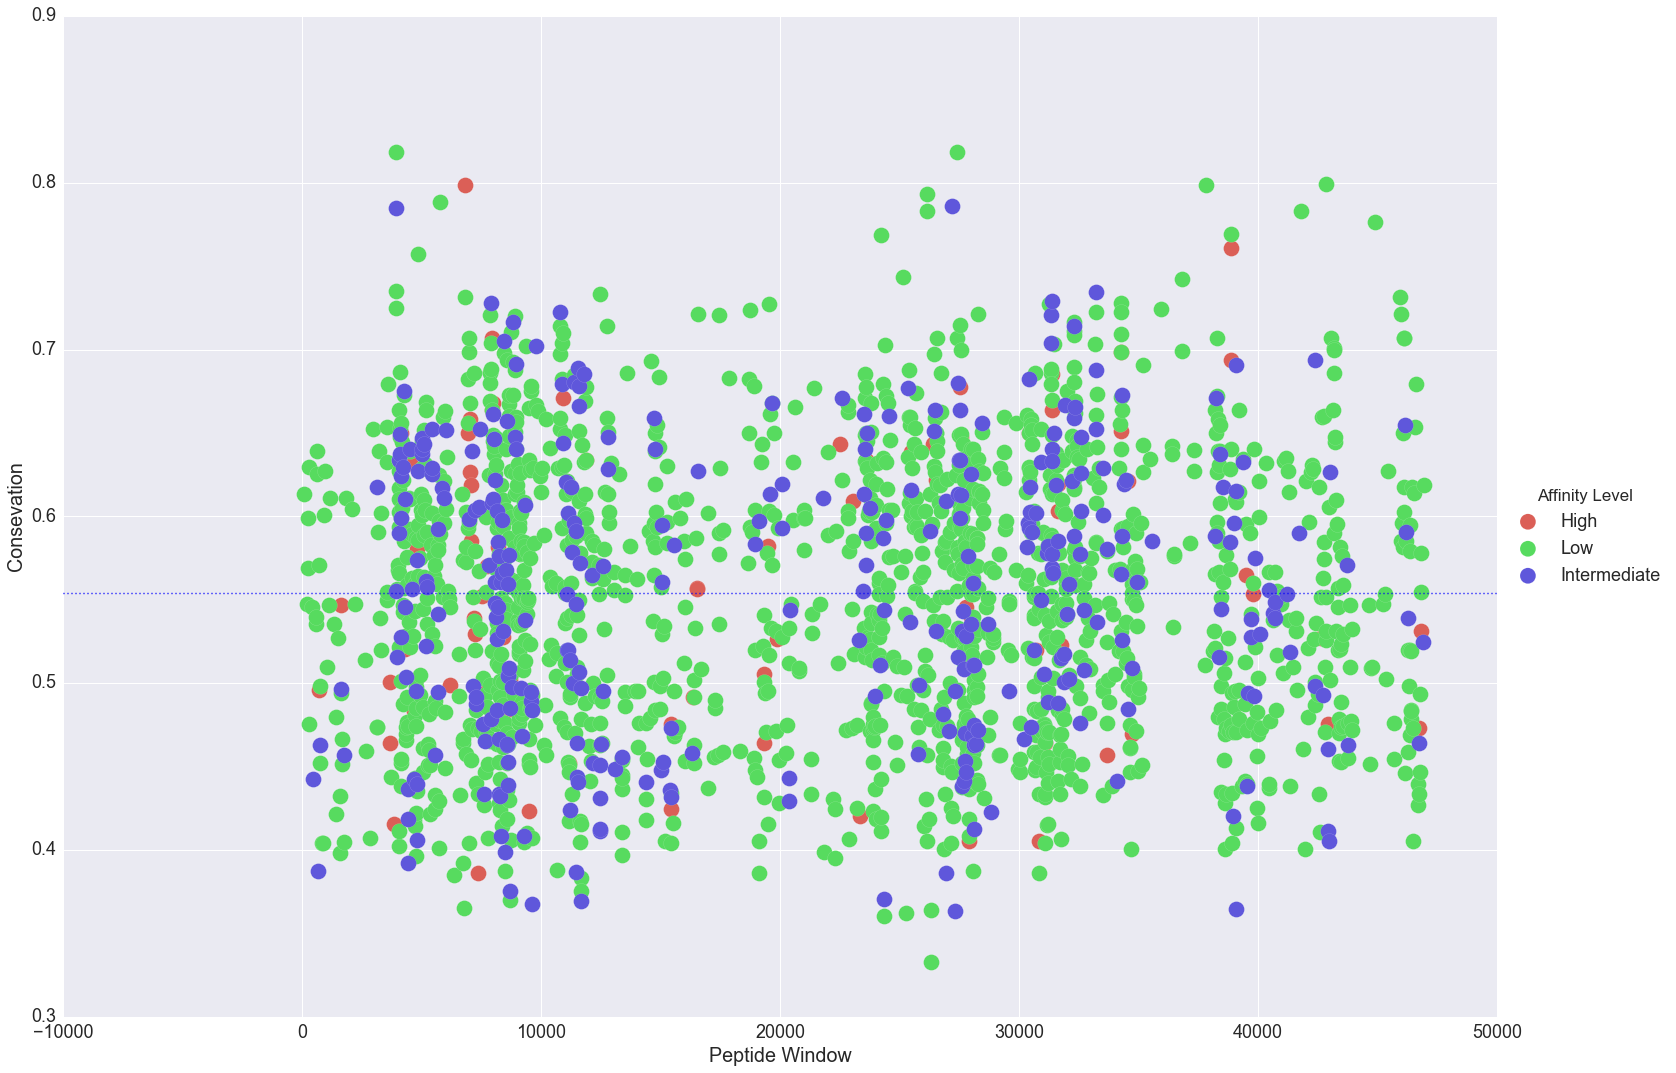

In [142]:
from nepitope import summary_data
%matplotlib inline

single_prot = summary_data.SummaryData.summarize_without_blast_dat(scores_and_affinity)
single_prot.plot_affinity_versus_conservation_score()
single_prot.print_table()
allele_list = single_prot.alleles

In [14]:
csv_path = '/Users/carlomazzaferro/Desktop/CCBB_Results_Immune_Stealth_Analysis/summary_protein_data_per_peptide.csv'
single_prot.my_df.to_csv(path_or_buf=csv_path, sep=',')

### Adding conservation alignment and high affinity peptide data   
In this way, the alignment can have such data in it that can be straightforwardly visualized

In [165]:
importlib.reload(msa_utils)

<module 'nepitope.msa_utils' from '/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/msa_utils.py'>

In [167]:
msa_file = '/Users/carlomazzaferro/Desktop/PROJECT_LOC_TEST/alignment/MSA.fasta'
msa_file_out =  '/Users/carlomazzaferro/Desktop/PROJECT_LOC_TEST/alignment/MSA_affinity_added.fasta'
positional_conservation = MSA_STUFF.positional_conservation
scores_affinity_df = scores_and_affinity[0]

msa_file_add_data = msa_utils.AddData(msa_file, msa_file_out, scores_affinity_df,
                                          positional_conservation, all_alleles=True, pos_cons_treshold=0.7)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/msa_utils.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.396215626352
0.474015626461
0.460291379486
0.372280746348
0.518035978627
0.506079645305
0.582732623004
0.417561024922


In [168]:
msa_file_add_data.open_files()  ###should be renamed to open_and_write_to_msa. It indeed does both.

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/msa_utils.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Transform in HTML file so that can be opened easily
Vizualise results in MSA alignment file

In [169]:
msa_file_add_data.visualize_alignemnt()

MSA in html created to /Users/carlomazzaferro/Desktop/PROJECT_LOC_TEST/alignment/MSA_easy_viewing.html


>*Circles*: location of high conservation (on line: conservation info)

>*Peptides at the bottom*: location of high-affinity value

## Top 10 swap candidates and their analogues
Since we have the position of the high affinity, low conservation peptides, we can infer from them the potential peptides from other proteins likely to be good swaps. We'll do this by accessing the fasta file containing all protein sequeces. Further, to avoid false positives, we'll consider only Scores of 0 (or very close to 0).

In [171]:
high_aa_low_cons_df = msa_file_add_data.high_affinity_low_cons_df()
high_aa_low_cons_df.sort_values(by='nM')

,Pos,Peptide,nM,Rank,ID,Allele,Affinity Level,n-mer,Score
1802,1802,EIIEQISEF,2.9,0.010,S__pyogenes_Cas9,HLA-A2601,High,9,0.582390
680,680,SLLYEYFTV,5.1,0.030,S__pyogenes_Cas9,HLA-A0201,High,9,0.529800
1799,1799,YLDEIIEQI,5.5,0.040,S__pyogenes_Cas9,HLA-A0201,High,9,0.570468
381,381,ILLSDILRV,5.6,0.040,S__pyogenes_Cas9,HLA-A0201,High,9,0.619140
681,681,LLYEYFTVY,6.6,0.020,S__pyogenes_Cas9,HLA-B1501,High,9,0.519672
1083,1083,KELG-SQIL,7.3,0.020,S__pyogenes_Cas9,HLA-B4001,High,9,0.527244
1435,1435,KATAKYF-F,7.9,0.040,S__pyogenes_Cas9,HLA-B5801,High,9,0.473399
211,211,MIKFRGHFL,8.3,0.010,S__pyogenes_Cas9,HLA-B0801,High,9,0.622007
1327,1327,RE-VKV-ITL,8.7,0.030,S__pyogenes_Cas9,HLA-B4001,High,10,0.553717
601,601,ILTFRIPYYV,9.2,0.100,S__pyogenes_Cas9,HLA-A0201,High,10,0.545876


# Save to csv.
csv_path = '/Users/carlomazzaferro/Desktop/top_peptides_of_interest.csv'
high_aa_low_cons_df.to_csv(path_or_buf=csv_path, sep=',')

In [ ]:
# Summary Data: All Proteins
